## Classical mechanics problems

### Prerequisites

In [3]:
import numpy as np

def ode_euler_step(f, x, t, h):
    """Perform a single step h using Euler's scheme.

    Args:
    f: the function that defines the ODE.
    x: the value of the dependent variable at the present step.
    t: the present value of the time variable.
    h: the time step

    Returns:
    xnew: the value of the dependent variable at the step t+h
    """
    return x + h * f(x,t)

def ode_rk4_step(f, x, t, h):
    """Perform a single step h using 4th order Runge-Kutta method.

    Args:
    f: the function that defines the ODE.
    x: the value of the dependent variable at the present step.
    t: the present value of the time variable.
    h: the time step

    Returns:
    xnew: the value of the dependent variable at the step t+h
    """
    k1 = h * f(x,t)
    k2 = h * f(x + k1/2., t + h /2.)
    k3 = h * f(x + k2/2., t + h /2.)
    k4 = h * f(x + k3, t + h)
    return x + (k1 + 2. * k2 + 2. * k3 + k4) / 6.

# The default definition of the error (distance) between two state vectors 
# Default: the magnitude of the difference vector
def distance_definition_default(x1, x2):
    diff = x1 - x2
    diffnorm = np.sqrt(np.dot(diff, diff))
    return diffnorm

def ode_rk4_adaptive_multi(f, x0, t0, h0, tmax, delta = 1.e-6, distance_definition = distance_definition_default):
    """Solve an ODE dx/dt = f(x,t) from t = t0 to t = t0 + h*steps 
    using 4th order Runge-Kutta method with adaptive time step.

    Args:
          f: the function that defines the ODE.
         x0: the initial value of the dependent variable.
         t0: the initial value of the time variable.
         h0: the initial time step
       tmax: the maximum time
      delta: the desired accuracy per unit time

    Returns:
    t,x: the pair of arrays corresponding to the time and dependent variables
    """
    
    ts = [t0]
    xs = [x0]
    
    h = h0
    t = t0
    i = 0
        
    while (t < tmax):
        if (t + h >= tmax):
            ts.append(tmax)
            h = tmax - t
            xs.append(ode_rk4_step(f, xs[i], ts[i], h))
            t = tmax
            break
        
        x1 = ode_rk4_step(f, xs[i], ts[i], h)
        x1 = ode_rk4_step(f, x1, ts[i] + h, h)
        x2 = ode_rk4_step(f, xs[i], ts[i], 2*h)
        
        diffnorm = distance_definition(x1, x2)
        if diffnorm == 0.: # To avoid the division by zero
            rho = 2.**4
        else:
            rho = 30. * h * delta / diffnorm
        if rho < 1.:
            h *= rho**(1/4.)
        else:
            if (t + 2.*h) < tmax:
                xs.append(x1)
                ts.append(t + 2*h)
                t += 2*h
            else:
                xs.append(ode_rk4_step(f, xs[i], ts[i], h))
                ts.append(t + h)
                t += h
            i += 1
            h = min(2.*h, h * rho**(1/4.))
        
    return ts,xs

def ode_leapfrog_step(f, x, x2, t, h):
    """Perform a single step h using the leapfrog method.

    Args:
     f: the function that defines the ODE.
     x: the value of x(t)
    x2: the value of x(t+h/2)
     t: the present value of the time variable.
     h: the time step

    Returns:
    xnew, xnew2: the value of the dependent variable at the steps t+h, t+3h/2
    """
    
    xnew = x + h * f(x2,t+h/2.)
    xnew2 = x2 + h * f(xnew, t + h)
    return xnew, xnew2

def ode_MMM_multi(f, x0, t0, H, nsteps):
    """Multi-dimensional version of the modified midpoint method.
    """
    
    h = H / nsteps
    t = np.zeros(nsteps + 1)
    x = np.zeros((len(t), len(x0)))
    x2 = np.zeros(len(x0))
    t = t0
    x = x0
    y = ode_euler_step(f, x0, t0, h/2.)
    for i in range(0, nsteps):
        yprev = y
        x, y = ode_leapfrog_step(f, x, y, t, h)
        t = t + h
        
    return 0.5 * (x + yprev + 0.5 * h * f(x,t))

def bulirsch_stoer_step(f, x0, t0, H, delta = 1.e-6, distance_definition = distance_definition_default, maxsteps = 10):
    """Use Bulirsch-Stoer method to integrate for t to t+H.
    """
    n = 1
    R1 = np.empty([1,len(x0)],float)
    R1[0] = ode_MMM_multi(f, x0, t0, H, 1)
    error = 2. * H * delta
    while (error > H*delta or n < 2) and n < maxsteps:
        n += 1
        R2 = R1
        R1 = np.empty([n,len(x0)],float)
        R1[0] = ode_MMM_multi(f, x0, t0, H, n)
        for m in range(1,n):
            epsilon = (R1[m-1]-R2[m-1])/((n/(n-1))**(2*m)-1)
            R1[m] = R1[m-1] + epsilon
        error = distance_definition(R1[n-2],R1[n-1])
        
    if n == maxsteps:
        # Reached maximum number of substeps in Bulirsch-Stoer method
        # reducing the time step and applying the method recursively
        sol1 = bulirsch_stoer_step(f, x0, t0, H/2., delta, distance_definition, maxsteps)
        sol2 = bulirsch_stoer_step(f, sol1[-1][1], t0 + H/2., H/2., delta, distance_definition, maxsteps)
        return sol1 + sol2
    
    return [[t0+H, R1[n - 1]]]

def bulirsch_stoer(f, x0, t0, nsteps, tmax, delta = 1.e-6, distance_definition = distance_definition_default, maxsubsteps = 10):
    """Use Bulirsch-Stoer method to integrate for t to tmax using nsteps Bulirsch-Stoer steps
    """
    H = (tmax - t0) / nsteps
    t = np.zeros(nsteps + 1)
    x = np.zeros((len(t), len(x0)))
    t = [t0]
    x = [x0]
    for i in range(0, nsteps):
        bst = bulirsch_stoer_step(f, x[-1], t[-1], H, delta, distance_definition, maxsubsteps)
        [t.append(el[0]) for el in bst]
        [x.append(el[1]) for el in bst]
    return t,x

## Three-body problem

Exercise 8.16 from M. Newman *Computational Physics*

We have three stars initially at rest and interacting through gravitational force.
The dimensionless parameters are the following:

|    Name        | Mass        | x           | y|
| ----------- | ----------- |----------- | ----------- |
| Star 1      | 150.        |  3 | 1 |
| Star 2      | 200.        | -1 | -2|
| Star 3      | 250.        | -1 | 1

The motion is in $z = 0$ plane.
The gravitation constant is taken to be $G = 1$

The equations of motion are
\begin{align*}
\frac{d^2 \mathbf{r}_1}{dt} &= G m_2 \frac{\mathbf{r}_2-\mathbf{r}_1}{|\mathbf{r}_2-\mathbf{r}_1|^3} +  G m_3 \frac{\mathbf{r}_3-\mathbf{r}_1}{|\mathbf{r}_3-\mathbf{r}_1|^3},\\
\frac{d^2 \mathbf{r}_2}{dt} &= G m_1 \frac{\mathbf{r}_1-\mathbf{r}_2}{|\mathbf{r}_1-\mathbf{r}_2|^3} +  G m_3 \frac{\mathbf{r}_3-\mathbf{r}_2}{|\mathbf{r}_3-\mathbf{r}_2|^3},\\
\frac{d^2 \mathbf{r}_3}{dt} &= G m_1 \frac{\mathbf{r}_1-\mathbf{r}_3}{|\mathbf{r}_1-\mathbf{r}_3|^3} + G m_2 \frac{\mathbf{r}_2-\mathbf{r}_3}{|\mathbf{r}_2-\mathbf{r}_3|^3}.
\end{align*}

In [4]:
f_evaluations = 0

def fthreebody(xin, t):
    global f_evaluations
    f_evaluations += 1
    
    x1 = xin[0]
    y1 = xin[1]
    x2 = xin[2]
    y2 = xin[3]
    x3 = xin[4]
    y3 = xin[5]
    
    r12 = np.sqrt((x1-x2)**2 + (y1-y2)**2)
    r13 = np.sqrt((x1-x3)**2 + (y1-y3)**2)
    r23 = np.sqrt((x2-x3)**2 + (y2-y3)**2)
    
    
    return np.array([xin[6],xin[7],xin[8],xin[9],xin[10],xin[11],
                     G * m2 * (x2 - x1) / r12**3 + G * m3 * (x3 - x1) / r13**3,
                     G * m2 * (y2 - y1) / r12**3 + G * m3 * (y3 - y1) / r13**3,
                     G * m1 * (x1 - x2) / r12**3 + G * m3 * (x3 - x2) / r23**3,
                     G * m1 * (y1 - y2) / r12**3 + G * m3 * (y3 - y2) / r23**3,
                     G * m1 * (x1 - x3) / r13**3 + G * m2 * (x2 - x3) / r23**3,
                     G * m1 * (y1 - y3) / r13**3 + G * m2 * (y2 - y3) / r23**3
                    ]
                   )

def error_definition_threebody(x1, x2):
    val = 0.
    for i in range(0,6):
        val += (x1[i] - x2[i])**2
    return np.sqrt(val)

def threebody_kinetic_energy(xin):
    val = 0.
    ms = [m1,m1,m2,m2,m3,m3]
    for i in range(0,6):
        val += ms[i] * xin[6 + i]**2 / 2.
    return val

def threebody_potential_energy(xin):
    x1 = xin[0]
    y1 = xin[1]
    x2 = xin[2]
    y2 = xin[3]
    x3 = xin[4]
    y3 = xin[5]
    
    r12 = np.sqrt((x1-x2)**2 + (y1-y2)**2)
    r13 = np.sqrt((x1-x3)**2 + (y1-y3)**2)
    r23 = np.sqrt((x2-x3)**2 + (y2-y3)**2)
    return -G * m1 * m2 / r12 - G * m1 * m3 / r13 - G * m2 * m3 / r23

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[ 1.64092831  0.14107704 -2.00111541  1.03480693  0.61633534 -0.91249177
 12.17908348 -0.88372586 -7.11994634  1.3608435  -1.61149301 -0.55843928]


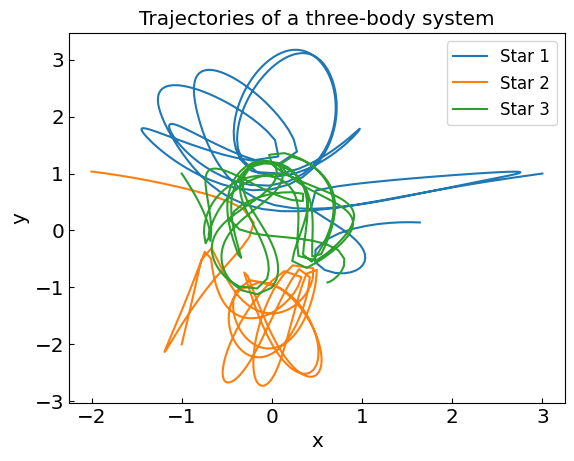

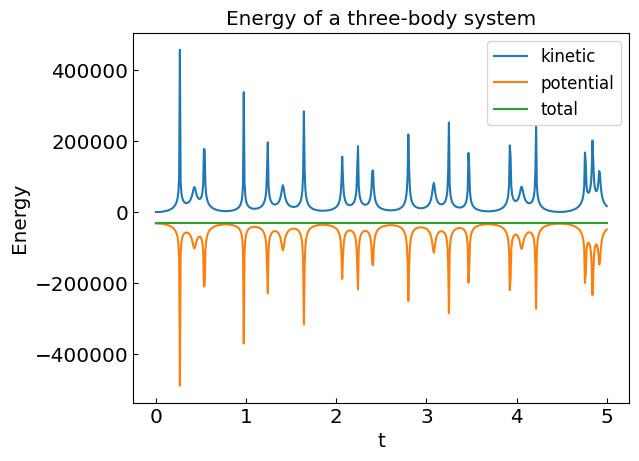

In [5]:
from vpython import *
scene = canvas() # This is needed in Jupyter notebook and lab to make programs easily rerunnable

G = 1
m1 = 150.
m2 = 200.
m3 = 250.

q0 = [3., 1., -1., -2., -1., 1., 0., 0., 0., 0., 0., 0.]
t0 = 0
tend = 5.

def calcpos(i, q):
    return vector(q[2*i], q[2*i+1],0.)


s1 = sphere(pos=calcpos(0,q0),radius=0.1,color=color.red, make_trail=True, retain=10)
s2 = sphere(pos=calcpos(1,q0),radius=0.1,color=color.green, make_trail=True, retain=10)
s3 = sphere(pos=calcpos(2,q0),radius=0.1,color=color.blue, make_trail=True, retain=10)


ts = [t0]
qs = [q0]
energies = [[threebody_kinetic_energy(q0)], 
            [threebody_potential_energy(q0)], 
            [threebody_kinetic_energy(q0) + threebody_potential_energy(q0)]]
cq = q0
eps = 1.e-6
fps = 120
dt = 1./fps
for ct in np.arange(t0, tend, dt):
    #rate(fps)
    #sol = bulirsch_stoer(fthreebody, cq, ct, 10, ct + dt, eps, error_definition_threebody)
    sol = ode_rk4_adaptive_multi(fthreebody, cq, ct, 0.5 * dt, ct+dt, eps, error_definition_threebody)
    cq = sol[1][-1]
    T = threebody_kinetic_energy(cq)
    V = threebody_potential_energy(cq)
    energies[0].append(T)    
    energies[1].append(V)
    energies[2].append(T+V)
    ts.append(ct + dt)
    qs.append(cq)
    
    
    #s1.pos = calcpos(0,cq)
    #s2.pos = calcpos(1,cq)
    #s3.pos = calcpos(2,cq)
    
print(qs[-1])
# Plot the energies
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'xtick.direction':'in',
         'ytick.direction':'in',
         }
plt.rcParams.update(params)

x1s = [q[0] for q in qs]
y1s = [q[1] for q in qs]
plt.plot(x1s,y1s, label = 'Star 1')
x2s = [q[2] for q in qs]
y2s = [q[3] for q in qs]
plt.plot(x2s,y2s, label = 'Star 2')
x3s = [q[4] for q in qs]
y3s = [q[5] for q in qs]
plt.plot(x3s,y3s, label = 'Star 3')
#plt.plot(ts, energies[1], label = 'potential')
#plt.plot(ts, energies[2], label = 'total')
plt.xlabel('x')
plt.ylabel('y')
plt.title("Trajectories of a three-body system")
plt.legend()
plt.show()

plt.plot(ts, energies[0], label = 'kinetic')
plt.plot(ts, energies[1], label = 'potential')
plt.plot(ts, energies[2], label = 'total')
plt.xlabel('t')
plt.ylabel('Energy')
plt.title("Energy of a three-body system")
plt.legend()
plt.show()

# Animate
cq = q0
eps = 1.e-6
fps = 60
dt = 1./fps
for ct in np.arange(t0, tend, dt):
    rate(fps)
    #sol = bulirsch_stoer(fthreebody, cq, ct, 10, ct + dt, eps, error_definition_threebody)
    sol = ode_rk4_adaptive_multi(fthreebody, cq, ct, 0.5 * dt, ct+dt, eps, error_definition_threebody)
    cq = sol[1][-1]
    s1.pos = calcpos(0,cq)
    s2.pos = calcpos(1,cq)
    s3.pos = calcpos(2,cq)

## Lagrangian mechanics

In Lagrangian mechanics, a classical system with $N$ degrees of freedom is characterized by generalized coordinates $\{q_j\}$ that obey Euler-Lagrange equations of motion:
$$
\frac{d}{dt} \left( \frac{\partial L}{\partial \dot{q}_j}\right ) - \frac{\partial L}{\partial q_j} = 0, \qquad j = 1\ldots N
$$

$L$ is the non-relativistic Lagrangian which is typically defined as the difference of kinetic and potential energies, $L = T - V$.
One can rewrite these equations using chain rules:
$$
\sum_{i=1}^N \frac{\partial^2 L}{\partial \dot{q}_j \, \partial \dot{q}_i} \ddot{q}_i = - \sum_{i=1}^N \frac{\partial^2 L}{\partial \dot{q}_j \, \partial q_i} \dot{q}_i -\frac{\partial^2 L}{\partial \dot{q}_j \, \partial t} + \frac{\partial L}{\partial q_j}, \qquad j = 1\ldots N.
$$
The term $-\frac{\partial^2 L}{\partial \dot{q}_j \, \partial t}$ in the r.h.s. corresponds to the scenario where we have explicit time dependence of the Lagrangian.

This is a system of $N$ linear equations which determines $\ddot{q}_i$ as function of $\{q_j\}$ and $\{\dot{q}_j \}$, i.e.
$$
\ddot{q}_i = f_i(\{q_j\},\{\dot{q}_j\},t).
$$
This system of 2nd-order ODE can be straightforwardly rewritten into $2N$ system of first-order ODEs 
\begin{align*}
\frac{d q_i}{dt} & = \dot{q}_i, \\
\frac{d \dot{q}_i}{dt} & = f_i(\{q_j\},\{\dot{q}_j\},t),
\end{align*}
and solved using standard methods.

## Non-linear pendulum

![pendulum](pendulum.gif)

The generalized coordinate of the non-linear pendulum is the displacement angle $\theta$.
One has 
$$
x = l \sin(\theta), \qquad y = -l \cos(\theta),
$$
thus the Lagrangian of a non-linear pendulum is
$$
L = T - V = \frac{m l^2 \dot{\theta}^2}{2} - m g l \cos(\theta),
$$
and the Lagrange equations of motion read
$$
m l \ddot{\theta} = - m g l \sin \theta.
$$


In [8]:
g = 9.81
L = 0.1
m = 1.

f_evaluations = 0

def fpendulum(xin, t):
    global f_evaluations
    f_evaluations += 1
    
    theta = xin[0]
    omega = xin[1]
    return np.array([omega,-g/L * np.sin(theta)])

def error_definition_pendulum(x1, x2):
    return np.abs(x1[0] - x2[0])

def pendulum_kinetic_energy(xin):
    theta = xin[0]
    omega = xin[1]
    return 0.5 * m * L**2 * omega**2

def pendulum_potential_energy(xin):
    theta = xin[0]
    omega = xin[1]
    return -m * g * L * cos(theta)

<IPython.core.display.Javascript object>

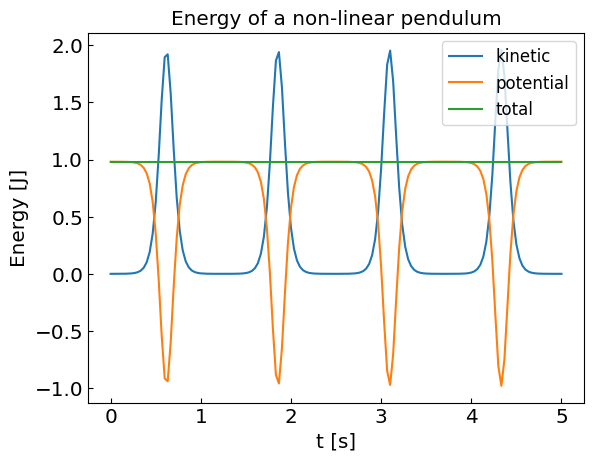

In [53]:
from vpython import *
scene = canvas() # This is needed in Jupyter notebook and lab to make programs easily rerunnable

theta0 = 179. * np.pi / 180.
omega0 = 0.
x0 = np.array([theta0,omega0])
eps = 1.e-8

t0 = 0.
tend = 5. # s
cx = x0


def calcpos(x):
    return vector(L*np.sin(x[0]), -L*np.cos(x[0]), 0)


ts = [t0]
qs = [x0]
energies = [[pendulum_kinetic_energy(x0)], [pendulum_potential_energy(x0)], [pendulum_kinetic_energy(x0) + pendulum_potential_energy(x0)]]

s = sphere(pos=calcpos(x0),radius=0.006,color=color.red, make_trail=True, retain=10)
rod = cylinder(pos=vector(0,0,0), axis=calcpos(x0), radius=0.0015,color=color.red)
fps = 30
dt = 1./fps
for ct in np.arange(t0, tend, dt):
    rate(fps)
    sol = bulirsch_stoer(fpendulum, cx, ct, 1, ct + dt, eps, error_definition_pendulum)
    #sol = ode_rk4_adaptive_multi(fpendulum, cx, ct, 0.5 * dt, ct+dt, eps, error_definition_pendulum)
    cx = sol[1][-1]
    s.pos = calcpos(cx)
    rod.axis = calcpos(cx)
    
    T = pendulum_kinetic_energy(cx)
    V = pendulum_potential_energy(cx)
    ts.append(ct + dt)
    qs.append(cx)
    energies[0].append(T)
    energies[1].append(V)
    energies[2].append(T+V)
    
# Plot the energies
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'xtick.direction':'in',
         'ytick.direction':'in',
         }
plt.rcParams.update(params)

plt.plot(ts, energies[0], label = 'kinetic')
plt.plot(ts, energies[1], label = 'potential')
plt.plot(ts, energies[2], label = 'total')
plt.xlabel('t [s]')
plt.ylabel('Energy [J]')
plt.title("Energy of a non-linear pendulum")
plt.legend()
plt.show()

In [51]:
# Visualize
def pendulum_plot(cx,ct):
    plt.xlabel("x [cm]")
    plt.ylabel("y [cm]")
    plt.xlim(-1.1*L*1.e2,1.1*L*1.e2)
    plt.ylim(-1.1*L*1.e2,1.1*L*1.e2)
    plt.axhline(y = 0., color = 'black', linestyle = '--')
    
    pos = calcpos(cx)*1.e2
    
    plt.plot([pos.x],[pos.y], 'o', color = 'red',label='mass')
    plt.plot([0.,pos.x],[0,pos.y], color = 'red',label='rod')
    
    labelrec = "Non-linear pendulum, t = " + "{:.2f}".format(ct) + " s"
    plt.title(labelrec)
    
    return plt

# Animate
import os
import matplotlib.animation as animation
import imageio

def system_animate(plotfunc, qall, tall, filename = 'pendulum.gif'):
    iterations = len(qall)
    labelgif = filename

    filenames = []
    for ind in range(0,iterations):
        # create file name and append it to a list
        filename = f'{ind}.png'
        filenames.append(filename)

        plot = plotfunc(qall[ind],tall[ind])
        plot.savefig(filename)
        plot.close()
        
    dt = tall[1] - tall[0]

    # build gif
    with imageio.get_writer(labelgif, mode='I', duration=dt) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

    # Remove files
    for filename in set(filenames):
        os.remove(filename)

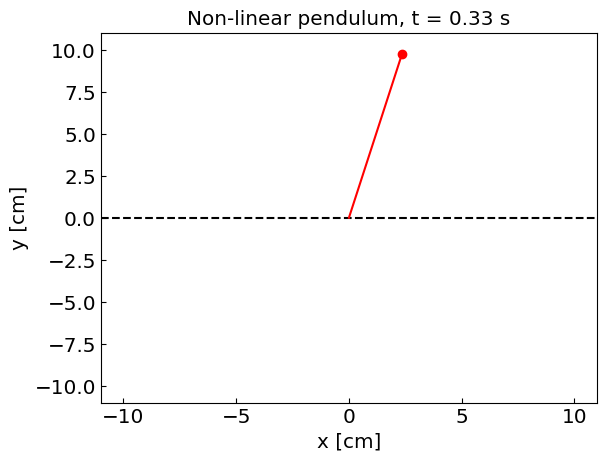

/tmp/ipykernel_416/1407568869.py:43: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [54]:
pendulum_plot(qs[10],ts[10]).show()
system_animate(pendulum_plot, qs, ts, 'nonlinear-pendulum.gif')

RK4 method with adaptive time step yields similarly accurate solution
Let us compare the number of function f evaluations in the two methods

In [55]:
theta0 = 179. * np.pi / 180.
omega0 = 0.
x0 = np.array([theta0,omega0])
eps = 1.e-10

t0 = 0.
tend = 10. # s

f_evaluations = 0
sol = bulirsch_stoer(fpendulum, x0, t0, 1, tend, eps, error_definition_pendulum, 10)

print("Integrating the non-linear pendulum from t =", t0, "to",tend,"s to accuracy of",eps,"per second using Bulirsch-Stoer method needs", 
      f_evaluations, "f(x,t) evaluations")

f_evaluations = 0
sol = ode_rk4_adaptive_multi(fpendulum, x0, t0, 0.5, tend, eps, error_definition_pendulum)

print("Integrating the non-linear pendulum from t =", t0, "to",tend,"s to accuracy of",eps,"per second using RK4 method needs", 
      f_evaluations, "f(x,t) evaluations")

Integrating the non-linear pendulum from t = 0.0 to 10.0 s to accuracy of 1e-10 per second using Bulirsch-Stoer method needs 57168 f(x,t) evaluations
Integrating the non-linear pendulum from t = 0.0 to 10.0 s to accuracy of 1e-10 per second using RK4 method needs 108004 f(x,t) evaluations


## Double pendulum

![double_pendulum](double_pendulum_scheme.gif)

Two degrees of freedom: the displacement angles $\theta_1$ and $\theta_2$.

We have
\begin{align*}
x_1 & = l_1 \sin(\theta_1), \\
y_1 & = -l_1 \cos(\theta_1), \\
x_2 & = l_1 \sin(\theta_1) + l_2 \sin(\theta_2), \\
y_2 & = -l_1 \cos(\theta_1) - l_2 \cos(\theta_2).
\end{align*}

The kinetic energy is
$$
T = \frac{m_1 \dot{x}_1^2}{2} + \frac{m_2 \dot{x}_2^2}{2}
= \frac{1}{2} m_1 l_1^2 \dot{\theta}_1 
+ \frac{1}{2} m_2 \left[ l_1^2 \dot{\theta}_1^2 + l_2^2 \dot{\theta}_2^2 
+ 2 l_1 l_2 \dot{\theta}_1 \dot{\theta_2} \cos(\theta_1 - \theta_2),
\right]
$$
and the potential energy is
$$
V = m_1 g y_1 + m_2 g y_2 = -(m_1+m_2) g l_1 \cos(\theta_1) - m_2 g l_2 \cos(\theta_2).
$$

The Lagrange equations of motion read
\begin{align*}
(m_1 + m_2) l_1 \ddot{\theta}_1 + m_2 l_2 \cos(\theta_1 - \theta_2) \ddot{\theta}_2 & =
-m_2 l_1 \dot{\theta}_2^2 \sin(\theta_1 - \theta_2) - (m_1+m_2) g \sin(\theta_1), \\
m_2 l_1 \cos(\theta_1 - \theta_2) \ddot{\theta}_1  + m_2 l_2 \ddot{\theta}_2 & =
m_2 l_1 \dot{\theta}_1^2 \sin(\theta_1 - \theta_2) - m_2 g \sin(\theta_2).
\end{align*}

This is a system of two linear equation for $ \ddot{\theta}_{1,2}$ that can be solved easily.

In [56]:
g = 9.81
l1 = 0.4
l2 = 0.4
m1 = 1.0
m2 = 1.0

def fdoublependulum(xin, t):
    global f_evaluations
    f_evaluations += 1
    
    theta1 = xin[0]
    theta2 = xin[1]
    omega1 = xin[2]
    omega2 = xin[3]
    a1 = (m1 + m2)*l1
    b1 = m2*l2*np.cos(theta1 - theta2)
    c1 = m2*l2*omega2*omega2*np.sin(theta1 - theta2) + (m1 + m2)*g*np.sin(theta1) # + 2.*k*l1*omega1 + k*l2*omega2*np.cos(theta1-theta2)
    a2 = m2*l1*np.cos(theta1 - theta2)
    b2 = m2*l2;
    c2 = -m2*l1*omega1*omega1*np.sin(theta1 - theta2) + m2*g*np.sin(theta2) # + k*l2*omega2 + k*l1*omega1*np.cos(theta1-theta2)
    domega1 = - ( c2/b2 - c1/b1 ) / ( a2/b2 - a1/b1 )
    domega2 = - ( c2/a2 - c1/a1 ) / ( b2/a2 - b1/a1 )
    return np.array([omega1,
                     omega2,
                     domega1,
                     domega2
                    ])

def error_definition_doublependulum(x1, x2):
    return np.abs(np.sqrt((x1[0] - x2[0])**2 + (x1[1] - x2[1])**2))

def kinetic_energy(xin):
    theta1 = xin[0]
    theta2 = xin[1]
    omega1 = xin[2]
    omega2 = xin[3]
    return 0.5 * m1 * l1**2 * omega1**2 + 0.5 * m2 * (l1**2 * omega1**2 + l2**2 * omega2**2 + 2.*l1*l2*omega1*omega2*np.cos(theta1-theta2))

def potential_energy(xin):
    theta1 = xin[0]
    theta2 = xin[1]
    omega1 = xin[2]
    omega2 = xin[3]
    return -m1 * g * l1 * cos(theta1) - m2 * g * (l1 * cos(theta1) + l2 * cos(theta2))

eps = 1.e-8

<IPython.core.display.Javascript object>

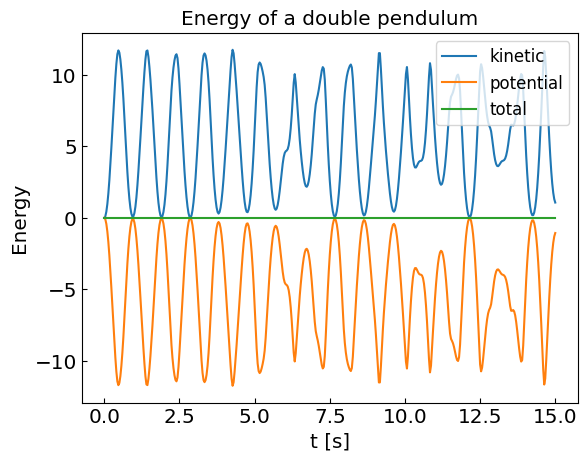

In [63]:
scene = canvas() # This is needed in Jupyter notebook and lab to make programs easily rerunnable

theta1_0 = np.pi / 2.
theta2_0 = np.pi / 2.
omega1_0 = 0.
omega2_0 = 0.
x0 = np.array([theta1_0, theta2_0,omega1_0,omega2_0])

t0 = 0.
tend = 15. # s
cx = x0

def calcpos1(x):
    return vector(l1*np.sin(x[0]), -l1*np.cos(x[0]), 0)

def calcpos2(x):
    return vector(l1*np.sin(x[0]) + l2*np.sin(x[1]), -l1*np.cos(x[0]) - l2*np.cos(x[1]), 0)

ts = [t0]
qs = [x0]
energies = [[kinetic_energy(x0)], [potential_energy(x0)], [kinetic_energy(x0) + potential_energy(x0)]]

s1 = sphere(pos=calcpos1(x0),radius=0.04,color=color.red, make_trail=True, retain=5)
rod1 = cylinder(pos=vector(0,0,0), axis=calcpos1(x0), radius=0.007,color=color.red)
s2 = sphere(pos=calcpos2(x0),radius=0.04,color=color.blue, make_trail=True, retain=5)
rod2 = cylinder(pos=calcpos1(x0), axis=calcpos2(x0) - calcpos1(x0), radius=0.007,color=color.blue)
fps = 30
dt = 1./fps
for ct in np.arange(t0, tend, dt):
    rate(fps)
    sol = bulirsch_stoer(fdoublependulum, cx, ct, 1, ct + dt, eps, error_definition_doublependulum)
    #sol = ode_rk4_adaptive_multi(fdoublependulum, cx, ct, 0.5 * dt, ct+dt, eps, error_definition_doublependulum)
    cx = sol[1][-1]
    s1.pos = calcpos1(cx)
    rod1.axis = calcpos1(cx)
    s2.pos = calcpos2(cx)
    rod2.pos = calcpos1(cx)
    rod2.axis = calcpos2(cx) - calcpos1(cx)
    T = kinetic_energy(cx)
    V = potential_energy(cx)
    ts.append(ct + dt)
    qs.append(cx)
    energies[0].append(T)
    energies[1].append(V)
    energies[2].append(T+V)
    
# Plot the energies
plt.plot(ts, energies[0], label = 'kinetic')
plt.plot(ts, energies[1], label = 'potential')
plt.plot(ts, energies[2], label = 'total')
plt.xlabel('t [s]')
plt.ylabel('Energy')
plt.title("Energy of a double pendulum")
plt.legend()
plt.show()

In [64]:
# Visualize
def double_pendulum_plot(cx,ct):
    plt.xlabel("x [cm]")
    plt.ylabel("y [cm]")
    plt.xlim(-1.1*(l1+l2)*1.e2,1.1*(l1+l2)*1.e2)
    plt.ylim(-1.1*(l1+l2)*1.e2,1.1*(l1+l2)*1.e2)
    plt.axhline(y = 0., color = 'black', linestyle = '--')
    
    pos1 = calcpos1(cx)*1.e2
    pos2 = calcpos2(cx)*1.e2
    
    plt.plot([pos1.x],[pos1.y], 'o', color = 'red',label='mass')
    plt.plot([0.,pos1.x],[0,pos1.y], color = 'red',label='rod')
    plt.plot([pos2.x],[pos2.y], 'o', color = 'blue',label='mass')
    plt.plot([pos1.x,pos2.x],[pos1.y,pos2.y], color = 'blue',label='rod')
    
    labelrec = "Double pendulum, t = " + "{:.2f}".format(ct) + " s"
    plt.title(labelrec)
    
    return plt


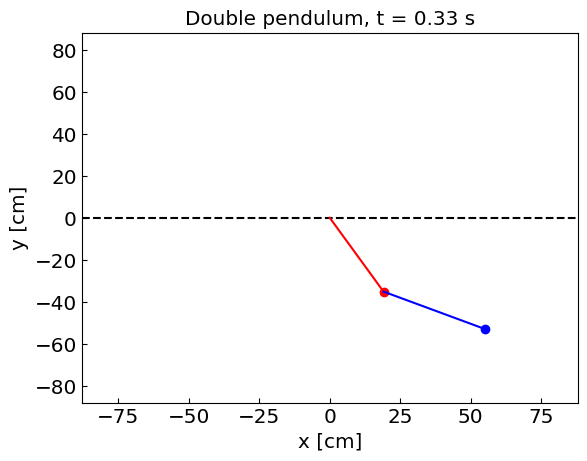

/tmp/ipykernel_416/1407568869.py:43: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [65]:
double_pendulum_plot(qs[10],ts[10]).show()
# write animation to file
# system_animate(double_pendulum_plot, qs, ts, 'double-pendulum-1.gif')

In [16]:
eps = 1.e-10
theta1_0 = np.pi / 2.
theta2_0 = np.pi / 2.
omega1_0 = 0.
omega2_0 = 0.
x0 = np.array([theta1_0, theta2_0,omega1_0,omega2_0])

t0 = 0.
tend = 10. # s

f_evaluations = 0
sol = bulirsch_stoer(fdoublependulum, x0, t0, 50, tend, eps, error_definition_doublependulum, 16)
print(sol[1][-1])

print("Integrating the double pendulum from t =", t0, "to",tend,"s to accuracy of",eps,"per second using Bulirsch-Stoer method needs", 
      f_evaluations, "f(x,t) evaluations")

f_evaluations = 0
sol = ode_rk4_adaptive_multi(fdoublependulum, x0, t0, 0.5, tend, eps, error_definition_doublependulum)
print(sol[1][-1])

print("Integrating the double pendulum from t =", t0, "to",tend,"s to accuracy of",eps,"per second using RK4 method needs", 
      f_evaluations, "f(x,t) evaluations")

[ -0.09988519 -11.30084112   5.80422414  -7.99371401]
Integrating the double pendulum from t = 0.0 to 10.0 s to accuracy of 1e-08 per second using Bulirsch-Stoer method needs 20644 f(x,t) evaluations
[ -0.09983888 -11.30006923   5.80158933  -7.99011927]
Integrating the double pendulum from t = 0.0 to 10.0 s to accuracy of 1e-08 per second using RK4 method needs 40796 f(x,t) evaluations


## Deterministic chaos

Let us perturb the initial conditions a bit
We track two systems with slightly different initial conditions

After some time the phase space trajectories diverge!
Despite the fact that equations of motion are deterministic, the system essentially loses all memory of the past.

Let us follow the trajectories of two systems with slightly different initial conditions.
For the second system we add $\delta \theta = 10^{-4}$ to the initial displacement angles $\theta_1$ and $\theta_2$.

<IPython.core.display.Javascript object>

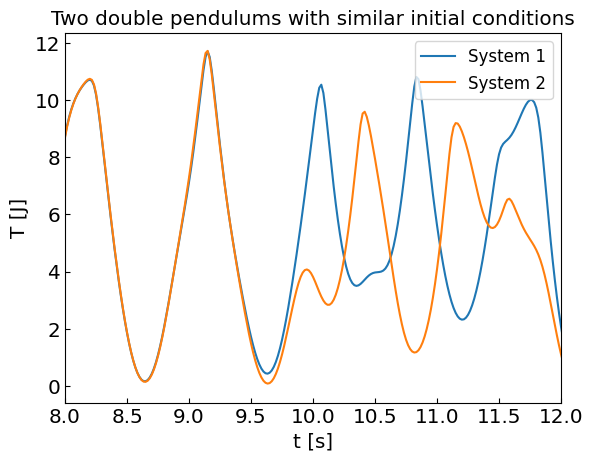

In [129]:
scene = canvas() # This is needed in Jupyter notebook and lab to make programs easily rerunnable

eps = 1.e-10
theta1_0 = np.pi / 2.
theta2_0 = np.pi / 2.
omega1_0 = 0.
omega2_0 = 0.
x0 = np.array([theta1_0, theta2_0,omega1_0,omega2_0])
deltheta = 1.e-4
x02 = np.array([theta1_0 + deltheta, theta2_0 + deltheta,omega1_0,omega2_0])


t0 = 0.
tend = 20. # s
cx = x0
cx2 = x02

ts = [t0]
energies = [[kinetic_energy(x0)], [potential_energy(x0)], [kinetic_energy(x0) + potential_energy(x0)]]
kinetic_energies = [ [kinetic_energy(x0)], [kinetic_energy(x02)] ]

s1 = sphere(pos=calcpos1(x0),radius=0.04,color=color.red, make_trail=True, retain=5)
rod1 = cylinder(pos=vector(0,0,0), axis=calcpos1(x0), radius=0.004,color=color.red)
s2 = sphere(pos=calcpos2(x0),radius=0.04,color=color.red, make_trail=True, retain=5)
rod2 = cylinder(pos=calcpos1(x0), axis=calcpos2(x0) - calcpos1(x0), radius=0.004,color=color.red)

s12 = sphere(pos=calcpos1(x02),radius=0.04,color=color.blue, make_trail=True, retain=5)
rod12 = cylinder(pos=vector(0,0,0), axis=calcpos1(x02), radius=0.004,color=color.blue)
s22 = sphere(pos=calcpos2(x02),radius=0.04,color=color.blue, make_trail=True, retain=5)
rod22 = cylinder(pos=calcpos1(x02), axis=calcpos2(x02) - calcpos1(x02), radius=0.004,color=color.blue)
fps = 60
dt = 1./fps
for ct in np.arange(t0, tend, dt):
    rate(fps)
    sol1 = bulirsch_stoer(fdoublependulum, cx, ct, 1, ct + dt, eps, error_definition_doublependulum)
    sol2 = bulirsch_stoer(fdoublependulum, cx2, ct, 1, ct + dt, eps, error_definition_doublependulum)
    # sol2 = ode_rk4_adaptive_multi(fdoublependulum, cx, ct, 1, ct + dt, eps, error_definition_doublependulum)
    cx  = sol1[1][-1]
    cx2 = sol2[1][-1]
    
    s1.pos = calcpos1(cx)
    rod1.axis = calcpos1(cx)
    s2.pos = calcpos2(cx)
    rod2.pos = calcpos1(cx)
    rod2.axis = calcpos2(cx) - calcpos1(cx)
    
    
    s12.pos = calcpos1(cx2)
    rod12.axis = calcpos1(cx2)
    s22.pos = calcpos2(cx2)
    rod22.pos = calcpos1(cx2)
    rod22.axis = calcpos2(cx2) - calcpos1(cx2)
    
    T = kinetic_energy(cx)
    V = potential_energy(cx)
    ts.append(ct + dt)
    energies[0].append(T)
    energies[1].append(V)
    energies[2].append(T+V)
    
    T2 = kinetic_energy(cx2)
    kinetic_energies[0].append(T)
    kinetic_energies[1].append(T2)
    
# Plot the kinetic energies
plt.plot(ts, kinetic_energies[0], label = 'System 1')
plt.plot(ts, kinetic_energies[1], label = 'System 2')
plt.xlabel('t [s]')
plt.ylabel('T [J]')
plt.xlim(8,12)
plt.title("Two double pendulums with similar initial conditions")
plt.legend()
plt.show()

In [66]:
scene = canvas() # This is needed in Jupyter notebook and lab to make programs easily rerunnable

theta1_0 = np.pi / 2.
theta2_0 = np.pi / 2.
omega1_0 = 0.
omega2_0 = 0.
deltheta = 1.e-4
x0 = np.array([theta1_0 + deltheta, theta2_0 + deltheta,omega1_0,omega2_0])

t0 = 0.
tend = 15. # s
cx = x0

ts = [t0]
qs = [x0]

fps = 30
dt = 1./fps
for ct in np.arange(t0, tend, dt):
    sol = bulirsch_stoer(fdoublependulum, cx, ct, 1, ct + dt, eps, error_definition_doublependulum)
    #sol = ode_rk4_adaptive_multi(fdoublependulum, cx, ct, 0.5 * dt, ct+dt, eps, error_definition_doublependulum)
    cx = sol[1][-1]
    ts.append(ct + dt)
    qs.append(cx)

<IPython.core.display.Javascript object>

In [67]:
system_animate(double_pendulum_plot, qs, ts, 'double-pendulum-2.gif')

/tmp/ipykernel_416/1407568869.py:43: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
